In [1]:
# 231108
# plot the eda for the datasets

In [2]:
import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import torch
# from tensorboardX import SummaryWriter

from options import args_parser
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar, WeightAverage
from utils import get_dataset, average_weights, exp_details, model_register_parametrization, model_remove_parametrizations
import torch.nn.utils.parametrize as parametrize

import random
import torch
from torch.utils.data import random_split, DataLoader
import numpy as np


In [3]:

import copy
import torch
from torchvision import datasets, transforms
from sampling import mnist_iid, mnist_noniid, mnist_noniid_unequal, mnist_noniid_mix
from sampling import cifar_iid, cifar_noniid
from torch import nn
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.nn.utils.parametrize as parametrize
from models import WeightAverageParametrization

In [4]:
import numpy as np
from torchvision import datasets, transforms

In [5]:
inputCommand = '--model=cnn --dataset=mnist --gpu=0 --iid=0 --epochs=20 --local_ep=1 --frac=1 --num_users=5 --scaffold=1 --weighted=0'

In [6]:
class myArgs:
    dataset = ''
    iid = 0
    unequal = 1
    num_classes = 10
    mix = 0
    num_users = 5

In [7]:
train_dataset, test_dataset, user_groups = get_dataset(myArgs)

/home/kahou/anaconda3/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [8]:
train_dataset.targets.shape

torch.Size([60000])

In [9]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [10]:
trainSetReshape = train_dataset.data.reshape([60000, 28*28])
trainSetReshape.shape

torch.Size([60000, 784])

In [11]:
# user_groups.keys()
for tmpKey in user_groups.keys():
    print(user_groups[tmpKey].shape)

(2750,)
(9100,)
(19100,)
(10900,)
(18150,)


In [12]:
nSampleNumber = 5000

In [13]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
X = trainSetReshape[1:nSampleNumber]
# X = RobustScaler().fit_transform(X.T).T
# X = RobustScaler().fit_transform(X)
X = StandardScaler().fit_transform(X.T).T
# X = StandardScaler().fit_transform(X)

In [14]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto', 
                  random_state=29,
                  init='random', 
                  perplexity=200
                 ).fit_transform(X)

# from sklearn.manifold import MDS
# X_embedded = MDS(n_components=2, normalized_stress='auto').fit_transform(X)

# from sklearn.manifold import SpectralEmbedding
# X_embedded = SpectralEmbedding(n_components=2, random_state=29, affinity='rbf').fit_transform(X)


In [15]:
def plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr):
    '''
    input: label arr, x_embedded
    output: tsne
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    
    # colorArr = ["#9e0142", "#d53e4f", "#f46d43", "#fdae61", "#fee08b", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2"]
    
    # plt.figure()
    plt.figure(figsize=(10,10))
    for tmpIndex, tmpLabel in enumerate(np.unique(labelArr)):
        plt.scatter(X_embedded[labelArr == tmpLabel, 0], 
                    X_embedded[labelArr == tmpLabel, 1],
                    c = colorArr[tmpIndex], 
                    label = tmpLabel)
    plt.xlabel('tSNE1')
    plt.ylabel('tSNE2')
    plt.legend()
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [16]:
user_groups[0][1]

55152.0

In [17]:
colorArr = ["#9e0142", "#d53e4f", "#f46d43", "#fdae61", "#fee08b", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2", "#ffffbf"] # "#ffffbf",

In [18]:
labelArr = train_dataset.targets[1:nSampleNumber]

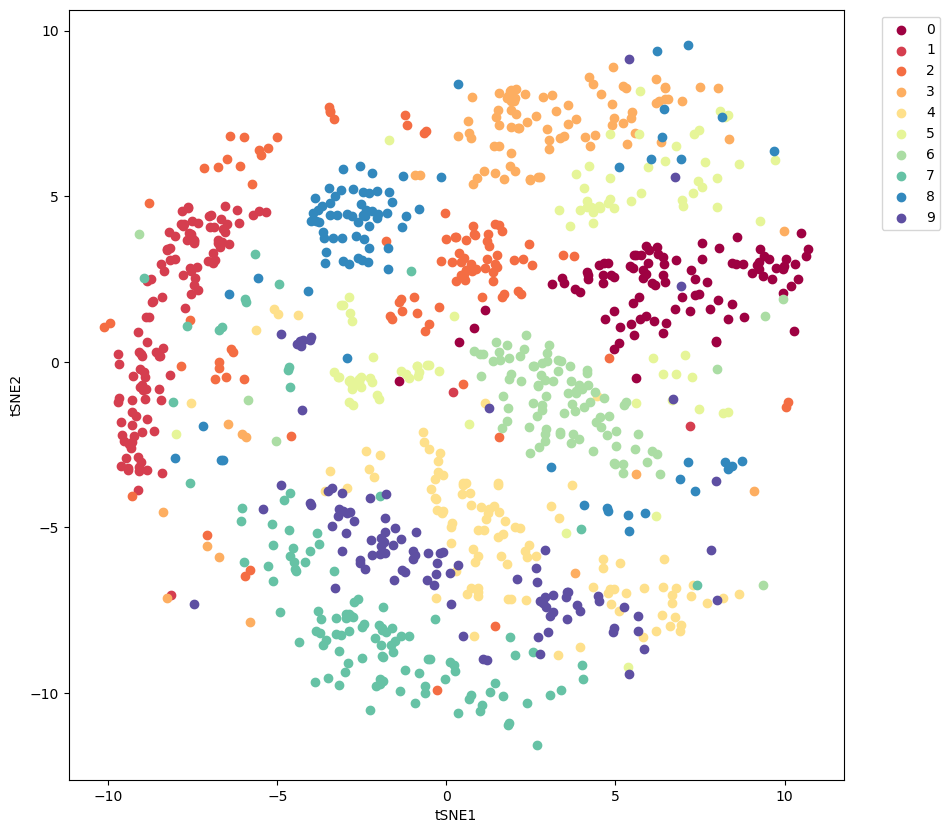

In [19]:
import matplotlib.pyplot as plt 

plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [20]:
clientLabelNpArr = np.zeros(trainSetReshape.shape[0])

In [21]:
# user_groups
# user_groups.keys()
for tmpKey in user_groups.keys():
    clientLabelNpArr[user_groups[tmpKey].astype(int)] = tmpKey

In [22]:
clientLabelNpArr

array([2., 4., 0., ..., 3., 2., 3.])

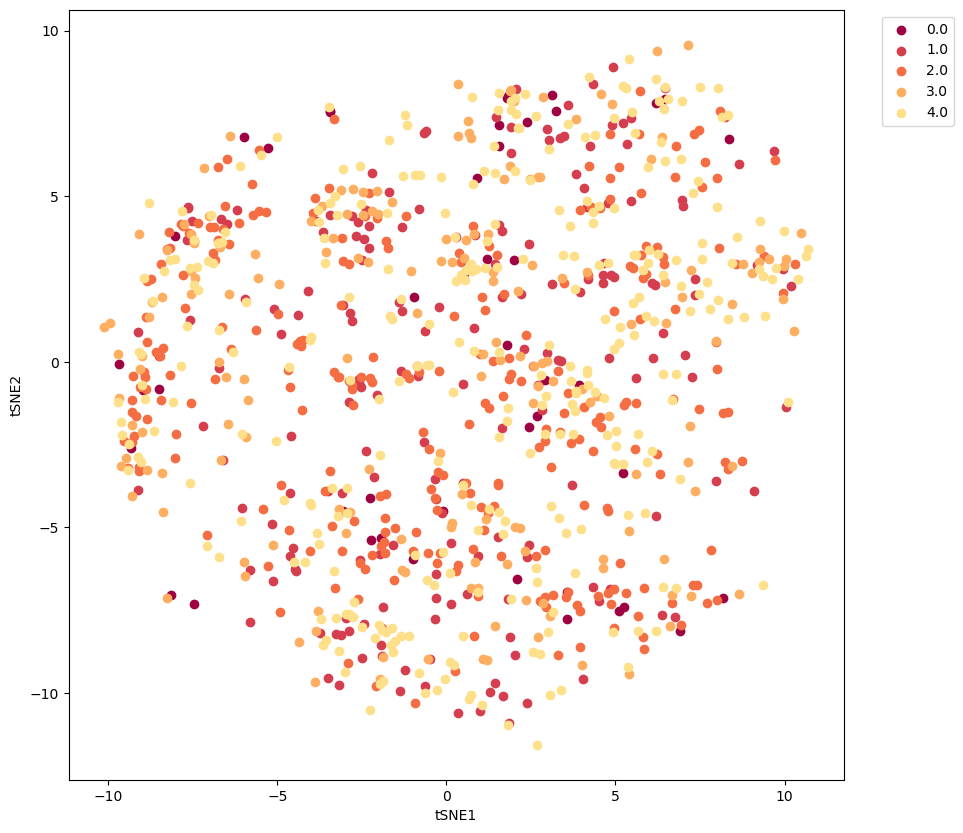

In [23]:
labelArr = clientLabelNpArr[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [24]:
class myArgs:
    dataset = ''
    iid = 0
    unequal = 0
    num_classes = 10
    mix = 0
    num_users = 5

In [25]:
train_dataset, test_dataset, user_groups = get_dataset(myArgs)

/home/kahou/anaconda3/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [26]:
trainSetReshape = train_dataset.data.reshape([60000, 28*28])

In [27]:
X = trainSetReshape[1:nSampleNumber]
X = StandardScaler().fit_transform(X.T).T

In [28]:
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto', 
                  random_state=29,
                  init='random', 
                  perplexity=200
                 ).fit_transform(X)

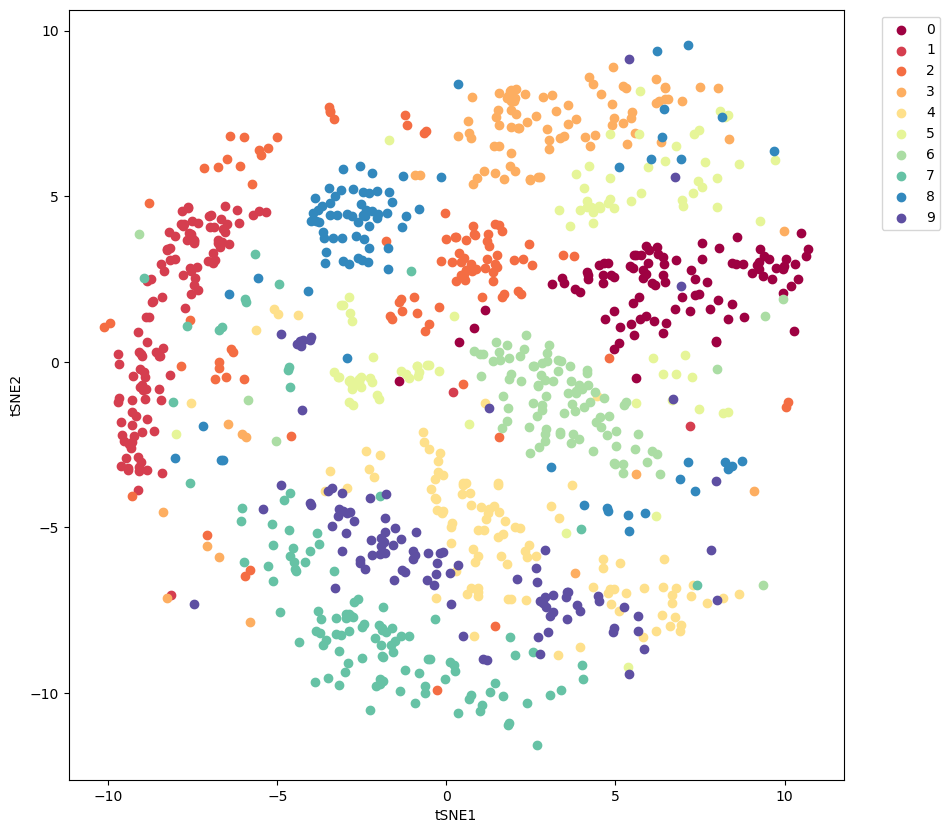

In [29]:
labelArr = train_dataset.targets[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [30]:
clientLabelNpArr = np.zeros(trainSetReshape.shape[0])
for tmpKey in user_groups.keys():
    clientLabelNpArr[user_groups[tmpKey].astype(int)] = tmpKey

In [31]:
colorArr2 = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

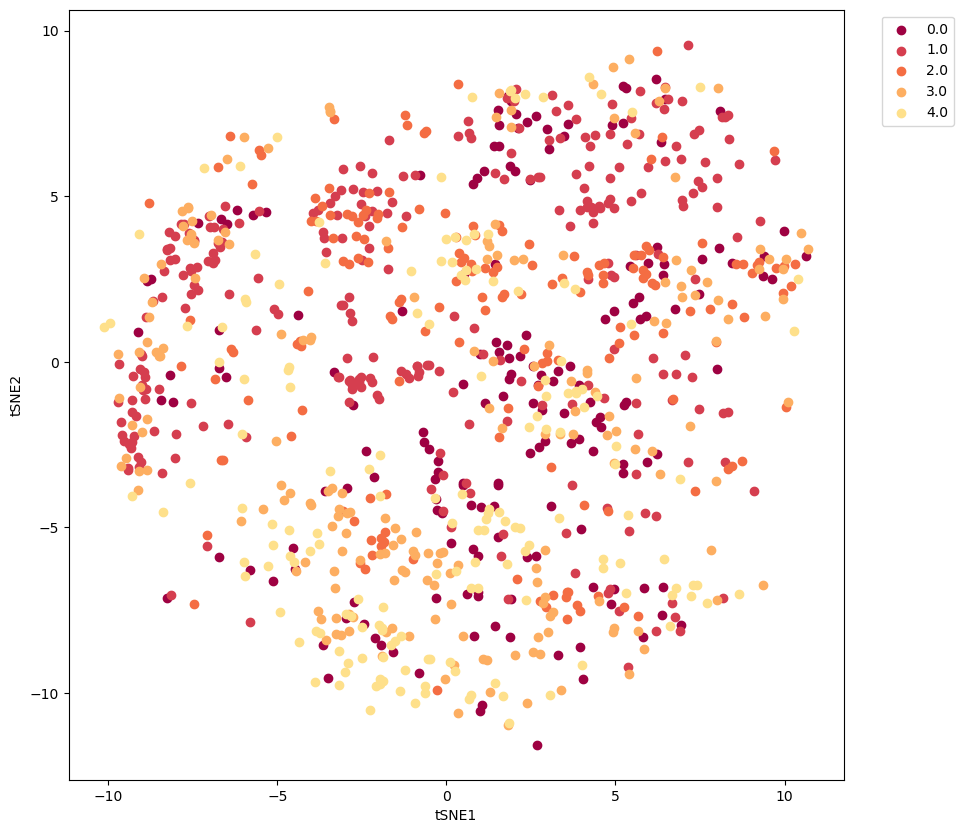

In [32]:
labelArr = clientLabelNpArr[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [33]:
class myArgs:
    dataset = ''
    iid = 1
    unequal = 0
    num_classes = 10
    mix = 0
    num_users = 5

In [34]:
train_dataset, test_dataset, user_groups = get_dataset(myArgs)

In [35]:
trainSetReshape = train_dataset.data.reshape([60000, 28*28])

In [36]:
X = trainSetReshape[1:nSampleNumber]
X = StandardScaler().fit_transform(X.T).T

In [37]:
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto', 
                  random_state=29,
                  init='random', 
                  perplexity=200
                 ).fit_transform(X)

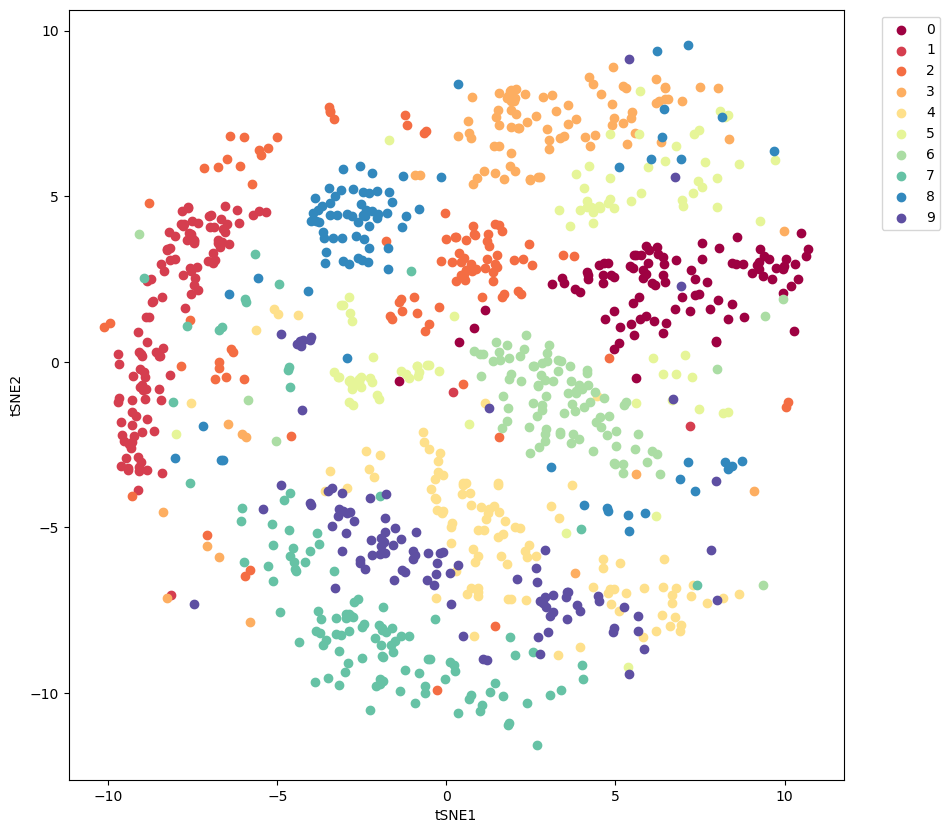

In [38]:
labelArr = train_dataset.targets[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [39]:
np.array(list(user_groups[tmpKey]))

array([32768,     6,    11, ..., 32737, 32743, 32755])

In [40]:
clientLabelNpArr = np.zeros(trainSetReshape.shape[0])
for tmpKey in user_groups.keys():
    clientLabelNpArr[np.array(list(user_groups[tmpKey]))] = tmpKey

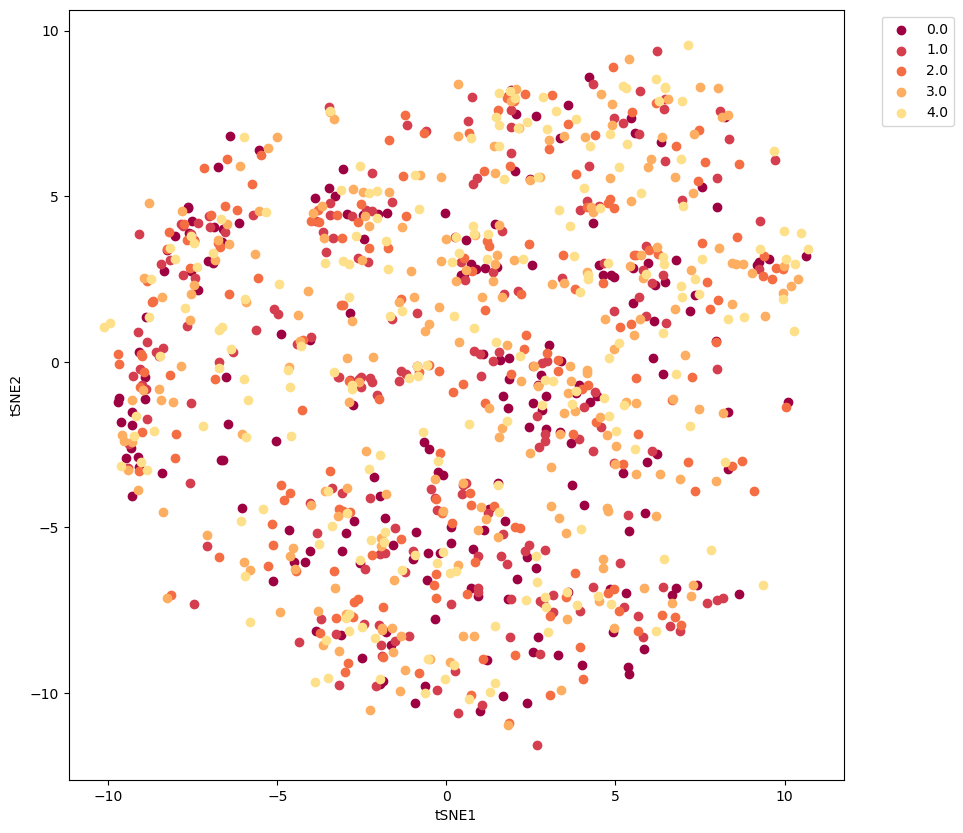

In [41]:
labelArr = clientLabelNpArr[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [42]:
class myArgs:
    dataset = ''
    iid = 0
    unequal = 0
    num_classes = 10
    mix = 1
    num_users = 5

In [43]:
train_dataset, test_dataset, user_groups = get_dataset(myArgs)

len(dict_users[i] 1:  6000
len(dict_users[i]) 2:  12000
len(dict_users[i] 1:  6000
len(dict_users[i]) 2:  12000
len(dict_users[i] 1:  6000
len(dict_users[i]) 2:  12000
len(dict_users[i] 1:  6000
len(dict_users[i]) 2:  12000
len(dict_users[i] 1:  6000
len(dict_users[i]) 2:  12000


/home/kahou/anaconda3/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [44]:
trainSetReshape = train_dataset.data.reshape([60000, 28*28])

In [45]:
X = trainSetReshape[1:nSampleNumber]
X = StandardScaler().fit_transform(X.T).T

In [46]:
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto', 
                  random_state=29,
                  init='random', 
                  perplexity=200
                 ).fit_transform(X)

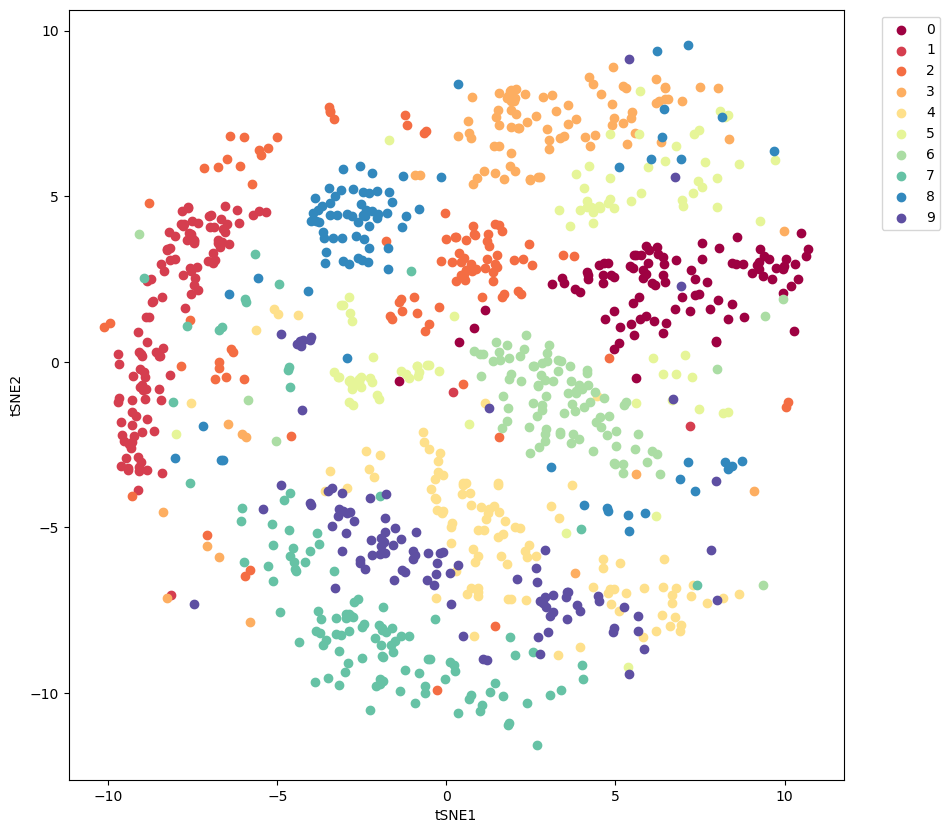

In [47]:
labelArr = train_dataset.targets[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [48]:
clientLabelNpArr = np.zeros(trainSetReshape.shape[0])
for tmpKey in user_groups.keys():
    clientLabelNpArr[user_groups[tmpKey].astype(int)] = tmpKey

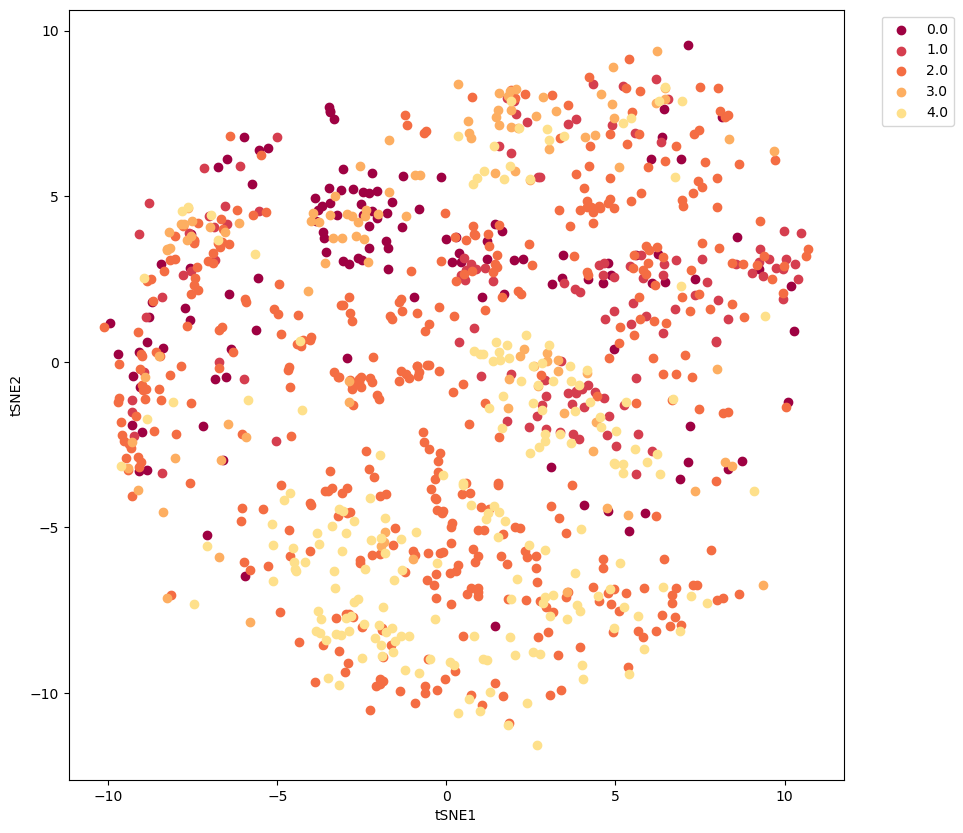

In [49]:
labelArr = clientLabelNpArr[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)